In [1]:
import duckdb

con = duckdb.connect(database="./../../database/data.duckdb", read_only=True)

In [2]:
from pandasql import sqldf
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
import os
from pyproj import Proj, transform
import numpy as np

In [3]:
commune = con.table("sise_communes").df()
prelev = con.table("sise_prelevements").df()
res = con.table("sise_resultats").df()

In [4]:
# quelles ARS et depuis quand elles analysent les PFAS ?

In [5]:
prelev.head()

,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,conclusionprel,ugelib,distrlib,moalib,plvconformitebacterio,plvconformitechimique,plvconformitereferencebact,plvconformitereferencechim
0,001,001000003,01007,AMBRONAY,None,None,None,00100139034,2024-01-23,11h27,Eau d'alimentation conforme aux limites de qua...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,N,C
1,001,001000003,01007,AMBRONAY,None,None,None,00100139393,2024-02-13,12h49,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C
2,001,001000003,01007,AMBRONAY,001001304,TTP (CLG) AMBRONAY,100 %,00100139969,2024-03-13,10h46,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C
3,001,001000003,01007,AMBRONAY,None,None,None,00100140209,2024-04-05,07h27,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C
4,001,001000003,01007,AMBRONAY,None,None,None,00100140543,2024-05-13,12h43,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C


In [6]:
# on clean le dataframe prelev

# on converti toutes les codes postaux en chaines de caractère
prelev["inseecommuneprinc"] = prelev["inseecommuneprinc"].astype(str)

In [7]:
# Liste des 20 PFAS actuellement recherchés par les ARS
pfas = np.array(
    [
        5977,
        5978,
        5979,
        5980,
        5347,
        6508,
        6507,
        6509,
        6510,
        6549,
        6025,
        8738,
        6830,
        6542,
        6560,
        8739,
        6550,
        8740,
        8741,
        8742,
    ]
)

res["libminparametre"][np.isin(res.cdparametre, pfas)].unique()

array(['Acide perfluorobutanoïque', 'Perfluorobutane sulfonate',
       'Acide perfluoro-decanoïque',
       'Acide perfluorododécanoique (PFDoDA)',
       'Acide perfluorododécane sulfonique (PFDoDS)',
       'Acide perfluorodecane sulfonique ', 'Acide perfluoroheptanoïque',
       'Acide perfluoroheptane sulfonique (PFHpS)',
       'Acide perfluorohexanoïque', 'Perfluorohexane sulfonate',
       'Acide perfluoro-nonanoïque',
       'Acide perfluorononane sulfonique (PFNS)',
       'Acide perfluoro-octanoïque', 'Acide perfluoropentanoïque',
       'Acide perfluoropentane sulfonique (PFPS)',
       'Acide perfluoro tridecanoique (PFTrDA)',
       'Acide perfluoro tridecane sulfonique (PFTrDS)',
       'Acide perfluoro undecanoïque (PFUnA)',
       'Acide perfluoro undecane sulfonique (PFUnDS)'], dtype=object)

In [8]:
pfas[np.invert(np.isin(pfas, res.cdparametre))]

array([6560])

Les données ne contiennent pas le PFAS 6560/"Acide perfluorooctane sulfonique", voir avec Pauline?

In [9]:
# Parmi tous les résultats on ne garde que les résultats qui mentionnent les PFAS
res_pfas = res[np.isin(res.cdparametre, pfas)]
res_pfas.head()

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl
35185,001,00100140027,PFBA,5980.0,ACIDE PERFLUOROBUTANOÏQUE,Acide perfluorobutanoïque,None,N,L,"0,0016",µg/L,133,None,None,0.0016,375-22-4,00100148857
35186,001,00100140027,PFBS,6025.0,PERFLUOROBUTANE SULFONATE,Perfluorobutane sulfonate,None,N,L,"<0,001",µg/L,133,None,None,0.0000,59933-66-3,00100148857
35187,001,00100140027,PFDA,6509.0,ACIDE PERFLUORO-DECANOÏQUE,Acide perfluoro-decanoïque,None,N,L,"<0,001",µg/L,133,None,None,0.0000,335-76-2,00100148857
35188,001,00100140027,PFDODA,6507.0,ACIDE PERFLUORODODÉCANOIQUE,Acide perfluorododécanoique (PFDoDA),None,N,L,"<0,001",µg/L,133,None,None,0.0000,307-55-1,00100148857
35189,001,00100140027,PFDODS,8741.0,ACIDE PERFLUORODODÉCANE SULFONIQUE,Acide perfluorododécane sulfonique (PFDoDS),None,N,L,"<0,001",µg/L,133,None,None,0.0000,79780-39-5,00100148857


La liste des départements qui ont mesuré les PFAS en 2024 est la suivante:

In [10]:
dpt_pfas = res_pfas["cddept"].astype(int).unique()
dpt_pfas

array([ 1,  3,  4,  5,  6,  7,  8, 11, 13, 18, 21, 25, 26, 28, 30, 34, 36,
       37, 38, 39, 41, 42, 45, 57, 58, 62, 63, 68, 69, 70, 71, 73, 74, 78,
       80, 83, 84, 86, 89, 90, 92])

In [11]:
res_pfas["cddept"] = res_pfas["cddept"].astype(int)

C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\56647353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_pfas["cddept"] = res_pfas["cddept"].astype(int)


Seuls 41 départements sur 111 ont déclaré des données sur les PFAS (sauf le 6560/"Acide perfluorooctane sulfonique") en 2024
L’arrêté basé sur la directive européenne (transposition en droit français en décembre 2022) fixe la limite de qualité à 0,10 µg/L pour la somme de ces 20 molécules dans les eaux de consommation humaines.

In [12]:
# Test bdd utilisées par les data eng

In [13]:
geo = pd.read_csv(
    r"C:\Users\emma.david\Desktop\data for good\13\13_pollution_eau\database\20230823-communes-departement-region (1).csv"
)

In [14]:
geo.head()

,code_commune_INSEE,nom_commune_postal,code_postal,libelle_acheminement,ligne_5,latitude,longitude,code_commune,article,nom_commune,nom_commune_complet,code_departement,nom_departement,code_region,nom_region
0,1001,L ABERGEMENT CLEMENCIAT,1400,L ABERGEMENT CLEMENCIAT,NaN,46.153426,4.926114,1.0,L',Abergement-Clémenciat,L'Abergement-Clémenciat,1,Ain,84.0,Auvergne-Rhône-Alpes
1,1002,L ABERGEMENT DE VAREY,1640,L ABERGEMENT DE VAREY,NaN,46.009188,5.428017,2.0,L',Abergement-de-Varey,L'Abergement-de-Varey,1,Ain,84.0,Auvergne-Rhône-Alpes
2,1004,AMBERIEU EN BUGEY,1500,AMBERIEU EN BUGEY,NaN,45.960848,5.372926,4.0,NaN,Ambérieu-en-Bugey,Ambérieu-en-Bugey,1,Ain,84.0,Auvergne-Rhône-Alpes
3,1005,AMBERIEUX EN DOMBES,1330,AMBERIEUX EN DOMBES,NaN,45.996180,4.912273,5.0,NaN,Ambérieux-en-Dombes,Ambérieux-en-Dombes,1,Ain,84.0,Auvergne-Rhône-Alpes
4,1006,AMBLEON,1300,AMBLEON,NaN,45.749499,5.594320,6.0,NaN,Ambléon,Ambléon,1,Ain,84.0,Auvergne-Rhône-Alpes


In [15]:
# données des tracés geo: https://github.com/gregoiredavid/france-geojson/tree/master

In [16]:
region = gpd.read_file(
    r"C:\Users\emma.david\Desktop\data for good\13\13_pollution_eau\database\regions-avec-outre-mer.geojson"
)

In [17]:
region.head()

,code,nom,geometry
0,11,Île-de-France,"POLYGON ((2.59052 49.07965, 2.59602 49.08171, ..."
1,24,Centre-Val de Loire,"POLYGON ((2.87463 47.52042, 2.87984 47.51671, ..."
2,27,Bourgogne-Franche-Comté,"POLYGON ((3.62942 46.74946, 3.62655 46.75228, ..."
3,28,Normandie,"MULTIPOLYGON (((-1.11962 49.35557, -1.11554 49..."
4,32,Hauts-de-France,"POLYGON ((4.1409 49.97876, 4.14407 49.97625, 4..."


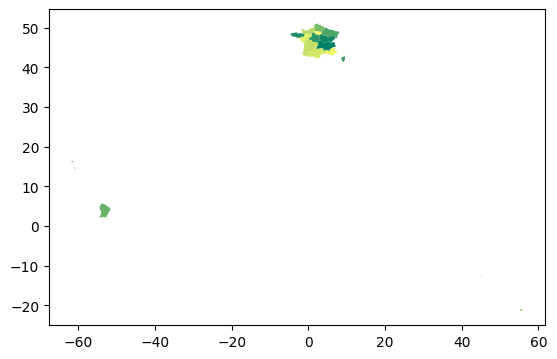

In [18]:
import matplotlib.pyplot as plt

region.plot(column="nom", cmap="summer")
plt.show()

In [19]:
geo_clean = geo.dropna(subset=["code_region"])
geo_clean["code_region"] = geo_clean["code_region"].astype(int)
geo_clean.head()

C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\1187646247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_clean["code_region"] = geo_clean["code_region"].astype(int)


,code_commune_INSEE,nom_commune_postal,code_postal,libelle_acheminement,ligne_5,latitude,longitude,code_commune,article,nom_commune,nom_commune_complet,code_departement,nom_departement,code_region,nom_region
0,1001,L ABERGEMENT CLEMENCIAT,1400,L ABERGEMENT CLEMENCIAT,NaN,46.153426,4.926114,1.0,L',Abergement-Clémenciat,L'Abergement-Clémenciat,1,Ain,84,Auvergne-Rhône-Alpes
1,1002,L ABERGEMENT DE VAREY,1640,L ABERGEMENT DE VAREY,NaN,46.009188,5.428017,2.0,L',Abergement-de-Varey,L'Abergement-de-Varey,1,Ain,84,Auvergne-Rhône-Alpes
2,1004,AMBERIEU EN BUGEY,1500,AMBERIEU EN BUGEY,NaN,45.960848,5.372926,4.0,NaN,Ambérieu-en-Bugey,Ambérieu-en-Bugey,1,Ain,84,Auvergne-Rhône-Alpes
3,1005,AMBERIEUX EN DOMBES,1330,AMBERIEUX EN DOMBES,NaN,45.996180,4.912273,5.0,NaN,Ambérieux-en-Dombes,Ambérieux-en-Dombes,1,Ain,84,Auvergne-Rhône-Alpes
4,1006,AMBLEON,1300,AMBLEON,NaN,45.749499,5.594320,6.0,NaN,Ambléon,Ambléon,1,Ain,84,Auvergne-Rhône-Alpes


In [20]:
# on sélectionne le code_region,nom_region des régions qui correspondent aux départements où on été étudiés les pfas en 2024
regions_pfas = sqldf("""SELECT code_region,nom_region
FROM geo_clean
WHERE code_departement IN
       (SELECT cddept FROM res_pfas)""")

Liste des régions ayant recherchés des PFAS en 2024 (par code de région):

In [21]:
regions_pfas["code_region"].unique()

array([84, 93, 44, 76, 24, 27, 32, 11, 75])

Liste des régions ayant recherchés des PFAS en 2024 (par nom):

In [22]:
regions_pfas["nom_region"].unique()

array(['Auvergne-Rhône-Alpes', "Provence-Alpes-Côte d'Azur", 'Grand Est',
       'Occitanie', 'Centre-Val de Loire', 'Bourgogne-Franche-Comté',
       'Hauts-de-France', 'Île-de-France', 'Nouvelle-Aquitaine'],
      dtype=object)

In [23]:
res_pfas.columns

Index(['cddept', 'referenceprel', 'cdparametresiseeaux', 'cdparametre',
       'libmajparametre', 'libminparametre', 'libwebparametre', 'qualitparam',
       'insituana', 'rqana', 'cdunitereferencesiseeaux', 'cdunitereference',
       'limitequal', 'refqual', 'valtraduite', 'casparam', 'referenceanl'],
      dtype='object')

In [24]:
geo_clean.columns

Index(['code_commune_INSEE', 'nom_commune_postal', 'code_postal',
       'libelle_acheminement', 'ligne_5', 'latitude', 'longitude',
       'code_commune', 'article', 'nom_commune', 'nom_commune_complet',
       'code_departement', 'nom_departement', 'code_region', 'nom_region'],
      dtype='object')

In [31]:
# cddept,res_pfas.cdparametre, res_pfas.rqana,res_pfas.referenceprel,res_pfas.libminparametre,res_pfas.refqual,res_pfas.valtraduite, res_pfas.casparam


res_pfas_regions = sqldf("""SELECT res_pfas.cddept,res_pfas.cdparametre, res_pfas.rqana,res_pfas.referenceprel,res_pfas.libminparametre,res_pfas.refqual,res_pfas.valtraduite, res_pfas.casparam,res_pfas.limitequal,geo_clean.code_departement,geo_clean.code_region,geo_clean.nom_region
FROM res_pfas
JOIN geo_clean
ON res_pfas.cddept = geo_clean.code_departement""")

In [32]:
res_pfas_regions.head()

,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,code_departement,code_region,nom_region
0,1,5347.0,"<0,001",00100140027,Acide perfluoro-octanoïque,None,0.0000,335-67-1,None,1,84,Auvergne-Rhône-Alpes
1,1,5977.0,"0,0016",00100140027,Acide perfluoroheptanoïque,None,0.0016,375-85-9,None,1,84,Auvergne-Rhône-Alpes
2,1,5978.0,"0,0054",00100140027,Acide perfluorohexanoïque,None,0.0054,307-24-4,None,1,84,Auvergne-Rhône-Alpes
3,1,5979.0,"0,0019",00100140027,Acide perfluoropentanoïque,None,0.0019,2706-90-3,None,1,84,Auvergne-Rhône-Alpes
4,1,5980.0,"0,0016",00100140027,Acide perfluorobutanoïque,None,0.0016,375-22-4,None,1,84,Auvergne-Rhône-Alpes


In [ ]:
res_pfas_regions["cdparametre"] = res_pfas_regions["cdparametre"].astype(int)
res_pfas_regions.head()

,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,code_departement,code_region,nom_region
0,1,5347,"<0,001",00100140027,Acide perfluoro-octanoïque,None,0.0000,335-67-1,None,1,84,Auvergne-Rhône-Alpes
1,1,5977,"0,0016",00100140027,Acide perfluoroheptanoïque,None,0.0016,375-85-9,None,1,84,Auvergne-Rhône-Alpes
2,1,5978,"0,0054",00100140027,Acide perfluorohexanoïque,None,0.0054,307-24-4,None,1,84,Auvergne-Rhône-Alpes
3,1,5979,"0,0019",00100140027,Acide perfluoropentanoïque,None,0.0019,2706-90-3,None,1,84,Auvergne-Rhône-Alpes
4,1,5980,"0,0016",00100140027,Acide perfluorobutanoïque,None,0.0016,375-22-4,None,1,84,Auvergne-Rhône-Alpes


In [34]:
res_pfas_regions.columns

Index(['cddept', 'cdparametre', 'rqana', 'referenceprel', 'libminparametre',
       'refqual', 'valtraduite', 'casparam', 'limitequal', 'code_departement',
       'code_region', 'nom_region'],
      dtype='object')

In [ ]:
res_pfas_groupregions = res_pfas_regions.groupby("code_region").agg(list)
res_pfas_groupregions.head()

# geo_clean_data = geo_clean.assign(qtt_pfas=pauvsect3["men_pauv"].div(pauvsect3["men"]))

,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,code_departement,nom_region
code_region,,,,,,,,,,,
11,"[78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 7...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[<0,001, <0,001, <0,002, <0,001, <0,001, <0,00...","[07800242644, 07800242644, 07800242644, 078002...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 7...","[Île-de-France, Île-de-France, Île-de-France, ..."
24,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[0,015, 0,004, 0,010, 0,011, 0,005, 0,004, <0,...","[01800094345, 01800094345, 01800094345, 018000...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.015, 0.004, 0.01, 0.011, 0.005, 0.004, 0.0,...","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[Centre-Val de Loire, Centre-Val de Loire, Cen..."
27,"[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[<0,0005, <0,0005, <0,001, <0,001, 0,0041, <0,...","[02100167243, 02100167243, 02100167243, 021001...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0041, 0.0, 0.0, 0.0, 0....","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2...","[Bourgogne-Franche-Comté, Bourgogne-Franche-Co..."
32,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[0,006, 0,001, <0,002, 0,002, 0,002, <0,001, <...","[06200285752, 06200285752, 06200285752, 062002...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.006, 0.001, 0.0, 0.002, 0.002, 0.0, 0.0, 0....","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[Hauts-de-France, Hauts-de-France, Hauts-de-Fr..."
44,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[0,0015, <0,001, 0,0038, 0,0033, 0,0016, 0,004...","[00800103772, 00800103772, 00800103772, 008001...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.0015, 0.0, 0.0038, 0.0033, 0.0016, 0.0044, ...","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[Grand Est, Grand Est, Grand Est, Grand Est, G..."


In [40]:
res_pfas_groupregions2 = res_pfas_groupregions.reset_index()

In [45]:
res_pfas_groupregions2.head()

,code_region,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,code_departement,nom_region
0,11,"[78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 7...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[<0,001, <0,001, <0,002, <0,001, <0,001, <0,00...","[07800242644, 07800242644, 07800242644, 078002...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 7...","[Île-de-France, Île-de-France, Île-de-France, ..."
1,24,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[0,015, 0,004, 0,010, 0,011, 0,005, 0,004, <0,...","[01800094345, 01800094345, 01800094345, 018000...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.015, 0.004, 0.01, 0.011, 0.005, 0.004, 0.0,...","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[Centre-Val de Loire, Centre-Val de Loire, Cen..."
2,27,"[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[<0,0005, <0,0005, <0,001, <0,001, 0,0041, <0,...","[02100167243, 02100167243, 02100167243, 021001...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0041, 0.0, 0.0, 0.0, 0....","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2...","[Bourgogne-Franche-Comté, Bourgogne-Franche-Co..."
3,32,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[0,006, 0,001, <0,002, 0,002, 0,002, <0,001, <...","[06200285752, 06200285752, 06200285752, 062002...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.006, 0.001, 0.0, 0.002, 0.002, 0.0, 0.0, 0....","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[Hauts-de-France, Hauts-de-France, Hauts-de-Fr..."
4,44,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[0,0015, <0,001, 0,0038, 0,0033, 0,0016, 0,004...","[00800103772, 00800103772, 00800103772, 008001...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.0015, 0.0, 0.0038, 0.0033, 0.0016, 0.0044, ...","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[Grand Est, Grand Est, Grand Est, Grand Est, G..."


In [55]:
df = res_pfas_groupregions2[["cdparametre"]]
df["cdparametre"] = df["cdparametre"].apply(lambda x: np.array(x))
df["cdparametre"] = df["cdparametre"].apply(lambda x: np.unique(x))
df["cdparametre"] = df["cdparametre"].apply(lambda x: np.unique(x).size)
df.head()
# res_pfas_groupregions3 = res_pfas_groupregions2.assign(cb_pfas=)

C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\3214782953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cdparametre'] = df['cdparametre'].apply(lambda x: np.array(x))
C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\3214782953.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cdparametre'] = df['cdparametre'].apply(lambda x: np.unique(x))
C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\3214782953.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,cdparametre
0,19
1,19
2,19
3,19
4,19


In [56]:
res_pfas_groupregions3 = res_pfas_groupregions2.assign(cb_pfas=df)

In [60]:
res_pfas_groupregions3[["nom_region", "cb_pfas"]]

,nom_region,cb_pfas
0,"[Île-de-France, Île-de-France, Île-de-France, ...",19
1,"[Centre-Val de Loire, Centre-Val de Loire, Cen...",19
2,"[Bourgogne-Franche-Comté, Bourgogne-Franche-Co...",19
3,"[Hauts-de-France, Hauts-de-France, Hauts-de-Fr...",19
4,"[Grand Est, Grand Est, Grand Est, Grand Est, G...",19
5,"[Nouvelle-Aquitaine, Nouvelle-Aquitaine, Nouve...",19
6,"[Occitanie, Occitanie, Occitanie, Occitanie, O...",19
7,"[Auvergne-Rhône-Alpes, Auvergne-Rhône-Alpes, A...",19
8,"[Provence-Alpes-Côte d'Azur, Provence-Alpes-Cô...",19


Parmis les 9 régions ayant recherchés des PFAS en 2024, toutes ont recherché 19 PFAS parmi la liste des 20 PFAS "reconnus". Le PFAS manquant est toujours le 6560/"Acide perfluorooctane sulfonique", entièrement absent de la base de données.

In [62]:
res_pfas_groupregions2.columns

Index(['code_region', 'cddept', 'cdparametre', 'rqana', 'referenceprel',
       'libminparametre', 'refqual', 'valtraduite', 'casparam', 'limitequal',
       'code_departement', 'nom_region'],
      dtype='object')

In [65]:
# on étudie maintenant le nombre de prélevements différents effectués sur les PFAS par région en 2024
df2 = res_pfas_groupregions2[["referenceprel"]]
df2["referenceprel"] = df2["referenceprel"].apply(lambda x: np.array(x))
df2["referenceprel"] = df2["referenceprel"].apply(lambda x: np.unique(x))
df2["referenceprel"] = df2["referenceprel"].apply(lambda x: np.unique(x).size)
df2.head()

C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\1656525643.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["referenceprel"] = df2["referenceprel"].apply(lambda x: np.array(x))
C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\1656525643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["referenceprel"] = df2["referenceprel"].apply(lambda x: np.unique(x))
C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\1656525643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a

,referenceprel
0,3
1,160
2,53
3,7
4,90


In [69]:
res_pfas_groupregions4 = res_pfas_groupregions3.assign(cb_prel=df2)

In [ ]:
# colonne clean pour le nom des régions
df3 = res_pfas_groupregions2[["nom_region"]]
df3["nom_region"] = df3["nom_region"].apply(lambda x: np.array(x)[0])
df3.head()

C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\4071933369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["nom_region"] = df3["nom_region"].apply(lambda x: np.array(x)[0])


,nom_region
0,Île-de-France
1,Centre-Val de Loire
2,Bourgogne-Franche-Comté
3,Hauts-de-France
4,Grand Est


In [71]:
res_pfas_groupregions5 = res_pfas_groupregions4.assign(nom_region_clean=df3)

Un tableau qui montre combien de prélèvements différents ont été effectués pour rechercher les PFAS par région en 2024:

In [73]:
res_pfas_groupregions5[["nom_region_clean", "cb_prel"]]

,nom_region_clean,cb_prel
0,Île-de-France,3
1,Centre-Val de Loire,160
2,Bourgogne-Franche-Comté,53
3,Hauts-de-France,7
4,Grand Est,90
5,Nouvelle-Aquitaine,1
6,Occitanie,75
7,Auvergne-Rhône-Alpes,493
8,Provence-Alpes-Côte d'Azur,399


In [74]:
# chercher les dates des prélèvements et les représenter graphiquement

Représentation cartographique des ARS ayant recherché au moins un PFAS en 2024:

In [ ]:
# m = folium.Map(location=[48.86, 2.33], zoom_start=12.5, tiles="cartodb positron")

cp = folium.Choropleth(
    geo_data=geo_clean,
    name="choropleth",
    data=geo_clean_data,
    columns=["nom_region", "men_pauv_prop"],
    key_on="feature.properties.nom_region",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Part de ménages pauvres",
).add_to(m)

folium.LayerControl().add_to(m)

folium.GeoJsonTooltip(["nom_region", "men_pauv_prop"]).add_to(cp.geojson)


m